# This is the final notebook, utilising Deep Neural Networks to predict Patent Classification Code

In [2]:
# Import all necessary packages

import ast
import nltk
import string
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
from keras.optimizers import SGD, RMSprop
from keras_preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt

from gensim.models import Word2Vec

from prettytable import PrettyTable

2023-07-27 15:34:05.611644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Preperation

In [3]:
# Load the data
df = pd.read_csv('Data_Preprocessed_SubGroup_Selected7.csv')
df['Classification Codes'] = df['Classification Codes'].apply(ast.literal_eval)
df.head()

,Context,Classification Codes
0,processor compil system receiv predict model r...,[G06N20/00]
1,system method secur cloudbas physiolog data pr...,"[A61B5/00, G16H10/60]"
2,collim detector base medic imag system medic i...,[A61B6/00]
3,insul pedicl access system relat method pedicl...,"[A61B5/00, A61B17/00]"
4,ingest event marker data framework ingest even...,"[A61B5/00, G16H10/60]"


In [4]:
# As most multi-label classifiers requres each class to have multiple instances.
# All codes which appear less than 5 times will be removed

for i in range(10):

    # Determine the codes to be removed
    unique_codes = df['Classification Codes'].explode().value_counts()
    codes_to_remove = unique_codes[unique_codes < 5 ].index.tolist()

    # Remove rows with empty 'Classification Codes' column
    df = df.dropna(subset=['Classification Codes'])

    # Remove codes in the list codes_to_remove
    df['CodeCount'] = df['Classification Codes'].apply(lambda codes: sum(code in codes_to_remove for code in codes))
    df = df[df['CodeCount'] == 0].drop(columns=['CodeCount'])

In [5]:
# Encode "Classification Codes" column as multi-labels
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Classification Codes'])

# Split the data into training(80%) and testing sets(20%)
X_train, X_test, y_train, y_test = train_test_split(df['Context'], y, test_size=0.2, random_state=42)

In [6]:
# Apply feature extraction using TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [7]:
# Convert sparse matrices to dense NumPy arrays
X_train_dense = X_train_vectorized.toarray()
X_test_dense = X_test_vectorized.toarray()

# Build and Train Neural Network

In [8]:
# Build the deep neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_dense.shape[1],)))
model.add(Dropout(0.3)) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='sigmoid'))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(X_train_dense, y_train, batch_size=16, epochs=10, validation_split=0.2, callbacks=[early_stopping])

# Make predictions
y_pred_proba = model.predict(X_test_dense)
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate the model
hamming_loss_value = hamming_loss(y_test, y_pred)

2023-07-27 15:34:13.285533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
243/243 [==============================] - 3s 10ms/step - loss: 0.3683 - accuracy: 0.5492 - val_loss: 0.2667 - val_accuracy: 0.6581
Epoch 2/10
243/243 [==============================] - 2s 8ms/step - loss: 0.2537 - accuracy: 0.7079 - val_loss: 0.2518 - val_accuracy: 0.7106
Epoch 3/10
243/243 [==============================] - 2s 8ms/step - loss: 0.2126 - accuracy: 0.7599 - val_loss: 0.2560 - val_accuracy: 0.7302
Epoch 4/10
243/243 [==============================] - 3s 13ms/step - loss: 0.1823 - accuracy: 0.7970 - val_loss: 0.2599 - val_accuracy: 0.7209
Epoch 5/10
243/243 [==============================] - 2s 8ms/step - loss: 0.1654 - accuracy: 0.8148 - val_loss: 0.2848 - val_accuracy: 0.7281
Epoch 5: early stopping
38/38 [==============================] - 0s 4ms/step


In [9]:
# Get accuracy and val accuracy
final_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]

# Print accuracy, val accuracy and hamming loss
print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print("\nHamming Loss:", hamming_loss_value)

Final Accuracy: 0.8148
Final Validation Accuracy: 0.7281

Hamming Loss: 0.08872675923746765


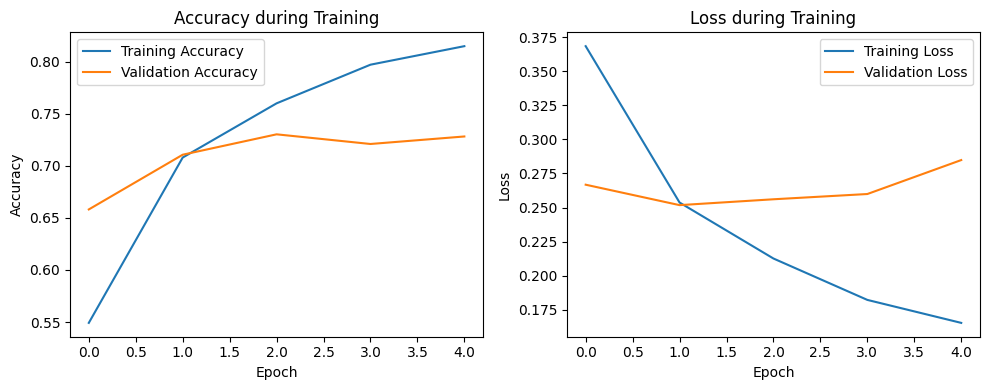

In [10]:
# Plot the training history
plt.figure(figsize=(10, 4))

# Accuracy/validation accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during Training')
plt.legend()

# Loss/validation loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss during Training')
plt.legend()

plt.tight_layout()
plt.show()

# Prediction

In [11]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenise the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Join the stemmed tokens back into a string
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [12]:
new_text = ["Cell Counting Device. The described invention is a cell counting device for counting target cells within a fluid, the device comprising: a microfluidic channel configured to receive a flow of a cell-containing fluid through an inlet and conduct the flow of the cell-containing fluid along the channel, the microfluidic channel sized such that target cells within the cell-containing fluid flow consecutively through the microfluidic channel; a first photodetector arranged to receive light that has passed through the microfluidic channel at a first measurement point, such that signal from the photodetector varies due to the received light being restricted by the passage of cells across the first measurement point in the microfluidic channel; a processing unit configured to receive a signal from the photodetector and distinguish the size of a cell passing the first measurement point based on an interruption time during which the signal intensity received from the photodetector is reduced, thereby determining the presence of a target cell type. Using an optical interruption signal in this way, provides a low cost device that does not require fluorescent dyes to label the cells nor does it require lasers, microscopes or other specialist equipment such that the device is suitable for point-of-care and at-home use and does not require the 20 direction of a trained specialist operator. A cell counting device for counting target cells within a fluid, the device comprising: a microfluidic channel configured to receive a flow of a cell-containing fluid through an inlet and conduct the flow of the cell-containing fluid along the channel, the microfluidic channel sized such that target cells within the cell-containing fluid flow consecutively through the microfluidic channel; a first photodetector arranged to receive light that has passed through the microfluidic channel at a first measurement point, such that signal from the photodetector varies due to the received light being restricted by the passage of cells across the first measurement point in the microfluidic channel; a processing unit configured to receive a signal from the photodetector and distinguish the size of a cell passing the first measurement point based on an interruption time during which the signal intensity received from the photodetector 15 is reduced, thereby determining the presence of a target cell type. The cell counting device according to claim 1 wherein the processing unit is configured to determine the presence of a target cell type based on both: the interruption time due to the passage of a cell across the first measurement point and the intensity variation of the signal during the interruption time. The cell counting device of claim 1 or claim 2 wherein the minimum width dimension of the microfluidic channel is less than the diameter of a target cell type within the fluid when in a relaxed state, such that the target cell type is deformed from its relaxed shape as it flows through the microfluidic channel. The cell counting device of any preceding claim further comprising: a second photodetector arranged to receive light that has passed through the  microfluidic channel at a second measurement point, such that signal from the photodetector varies due to the received light being restricted by the passage of cells across the second measurement point in the microfluidic channel; wherein the first measurement point and second measurement point are separated along the microfluidic channel in the flow direction; wherein the processing unit is configured to: receive signals from the first and second photodetectors and determine a speed at which a cell traverses a distance separating the first and second measurement points within the microfluidic channel; and determine the presence of a target cell type using the determined speed. The cell counting device of claim 4 wherein the minimum width dimension of the microfluidic channel is less than the diameter of a target cell type within the fluid when in a relaxed state, such that the target cell type is deformed from its relaxed shape as it flows through the microfluidic channel; wherein the processing unit is configured to: determine the size of the cell using the determined speed at which the cell is travelling and the interruption time of the signal received from the first and/or second photodetector. The cell counting device of any preceding claim comprising: an autofluorescence sensor comprising an excitation light source and an autofluorescence photodetector arranged to receive autofluorescence emissions from a cell illuminated by the excitation light source; wherein the processing unit is configured to receive signal from the autofluorescence photodetector and determine a the presence of a target cell type based on the intensity of the received signal. The cell counting device of any of claim 6 wherein the excitation light source is configured to provide light of wavelength in the range 250 – 700 nm. The cell counting device of claim 6 or 7 comprising: a first excitation light source configured to emit light of wavelength in the range 300 – 400 nm, preferably 360 – 370nm; and a second excitation light source configured to emit light of wavelength in range 400 – 500 nm, preferably 430-440 nm. The cell counting device of any of claims 6 to 8, wherein the autofluorescence photodetector is positioned on an opposite side of the microfluidic channel to the excitation light source, the cell counting device further comprising: an excitation light filter arranged between the microfluidic channel and the autofluorescence photodetector, the excitation light filter configured to block light in the wavelength range emitted by the excitation light source. The cell counting device of any of claims 6 to 9, wherein the autofluorescence photodetector comprises the first photodetector, wherein the processing unit is configured to receive signal from the first photodetector, wherein the signal comprises both: a varying intensity signal due to the received light being restricted by the passage of cells across the first measurement point in the microfluidic channel; and an autofluorescence signal due to the autofluorescence emissions received from a cell passing the first measurement point in the microfluidic channel. The cell counting device of any preceding claim wherein the microfluidic channel has a minimum width dimension of 1µm – 20 µm, preferably 5 – 15 µm, more preferably 8 – 12 µm. The cell counting device of any preceding claim wherein the target cells comprise blood cells and the microfluidic channel is sized such that the blood cells must pass consecutively through the microfluidic channel. The cell counting device of any preceding claim comprising: a second photodetector arranged to receive light that has passed through the microfluidic channel at a second measurement point, such that signal from the photodetector varies due to the received light being restricted by the passage of cells across the second measurement point in the microfluidic channel, wherein the first measurement point and second measurement point are separated along the microfluidic channel in the flow direction; and an autofluorescence sensor comprising an excitation light source configured to illuminate a cell as it passes an autofluorescence measurement point and an autofluorescence photodetector arranged to receive autofluorescence emissions from the illuminated cell; wherein the processing unit is configured to receive signals from the first photodetector, the second photodetector and the autofluorescence sensor and determine the presence of a target cell type within the microfluidic channel based on one or more of: the interruption time of the signal received from the first and/or second photodetector; the speed at which a cell traverses the microfluidic channel between the first and second measurement points determined from the signals received from the first and second photodetector; and the intensity of the signal received by the autofluorescence sensor. The cell counting device of claim 13 wherein the excitation light source is configured to provide excitation light comprising light in a first wavelength range for stimulating autofluorescence emission in a target 20 cell type, the cell counting device further comprising: an illumination light source configured to provide illumination light comprising light in a second wavelength range, wherein the illumination light source is configured to illuminate the microfluidic channel at the first and second measurement points to provide the signal to the first and second photodetectors; wherein the first photodetector, second photodetector and the autofluorescence photodetector are arranged on an opposite side of the microfluidic channel to the excitation light source and the illumination light source. The cell counting device of  claim 14 wherein the excitation light source is an ultraviolet light source and the illumination light source is an infra-red light source. The cell counting device of claim 14 or 15 further comprising: an excitation and autofluorescence filter positioned between the microfluidic channel and the photodetectors, the excitation and autofluorescence filter configured to block excitation and autofluorescence light but transmit illumination light, the excitation and autofluorescence filter comprising an opening aligned so as to permit autofluorescence light from a cell at the autofluorescence measurement point to reach the autofluorescence detector; an excitation and illumination light filter positioned between the excitation and autofluorescence light filter and the photodetectors, the excitation and illumination light filter configured to block excitation and illumination light but transmit autofluorescence light, the excitation and illumination light filter comprising two openings positioned so as to permit illumination light passing through the first and second measurement positions to reach the first and second photodetectors. The cell counting device of claim 14 or 15 further comprising: an excitation light filter positioned between the microfluidic channel and the photodetectors, the excitation light filter configured to block excitation light but transmit illumination light and autofluorescence light; an autofluorescence light filter positioned between the excitation light filter and the photodetectors, the autofluorescence light filter configured to block autofluorescence light but transmit illumination light, the autofluorescence light filter comprising an opening aligned so as to permit autofluorescence light from a cell at the autofluorescence measurement point to reach the autofluorescence detector; an illumination light filter positioned between the autofluorescence filter and the photodetectors, the illumination light filter configured to block illumination light and transmit autofluorescence light, the illumination light filter comprising two openings arranged to permit illumination light passing through the first and second measurement points to reach the first and second photodetectors. The cell counting device of any of claims 13 to 17 further comprising: a focal lens positioned between the excitation light source and the microfluidic channel, the focal lens configured to focus the excitation light towards the autofluorescence measurement point in a direction perpendicular to the microfluidic channel. The cell counting device of any of claims 13 to 18 wherein the autofluorescence photodetector comprises the first photodetector; wherein the processing unit is configured to receive signal from the first photodetector, wherein the signal comprises both: a varying intensity signal due to the received light being restricted by the passage of cells across the first measurement point in the microfluidic channel; and an autofluorescence signal due to the autofluorescence emissions received from a cell passing the first measurement point in the microfluidic channel. The cell counting device of claims 19 wherein the previously defined autofluorescence sensor is referred to as a first autofluorescence sensor, the cell counting device further comprising: a second autofluorescence sensor comprising a second excitation light source configured to illuminate a cell as it passes a second autofluorescence measurement point and a second autofluorescence photodetector arranged to receive autofluorescence emissions from the excited cell; wherein the second autofluorescence photodetector comprises the second photodetector; wherein the excitation light sources of the first and second autofluorescence sensors are configured to emit light of different wavelengths. The cell counting device of any preceding claim comprising: a plurality of microfluidic channels, each configured to receive a flow of a cell-containing fluid through an inlet and conduct the flow of the cell-containing fluid along the microfluidic channel, each microfluidic channel sized such that target cells within the cell-containing fluid flow consecutively through the microfluidic channel; a plurality of first photodetectors, each arranged to receive light that has passed through the  microfluidic channel at a first measurement point, such that signal from the photodetector varies due to the received light being restricted by the passage of cells across the first measurement point in the microfluidic channel; wherein the processor is configured to receive a signal from each of the plurality of first photodetectors, distinguish the size of cells passing through each of the microfluidic channels based on the received signal and count the number of target cell types flowing through the plurality of microfluidic channels. The cell counting device of claim 21 comprising a layered structure, the layered structure comprising: a microfluidic chip comprising the plurality of microfluidic channels in an array; a photodetector layer comprising the plurality of photodetectors; an optical filter layer arranged to block light from reaching the photodetector layer, wherein the optical filter comprises an array of openings arranged to allow light to pass through to the photodetector layer at positions corresponding to the measurement positions. The cell counting device of claims 21 or 22 further comprising a pressure relief channel, the pressure relief channel wider than any one of the microchannels and arranged to permit a portion of the received cellcontaining fluid to bypass the microfluidic channels, thereby regulating  the flow pressure in the microfluidic channels. A method for counting target cells within a cell-containing fluid, the method comprising: flowing a cell-containing fluid through a microfluidic channel sized such that target cells within the fluid flow consecutively through the microfluidic channel; illuminating the microfluidic channel with light from a first side of the microfluidic channel such that the light passes through the microfluidic channel and cell-containing fluid; receiving the light at the opposite side of the microfluidic channel with a photodetector such that signal from the photodetector varies due to the received light being restricted by the passage of cells across the microfluidic channel; distinguishing the size of a cell passing through the microfluidic channel based on the interruption time during which the signal received from the photodetector is reduced, thereby determining a target cell type. The method according to claim 24 further comprising: directing excitation light at a measurement position within the microfluidic channel, the excitation light having a wavelength suitable to excite autofluorescence in a target cell; receiving autofluorescence emissions from a cell at the measurement point with an autofluorescence photodetector distinguishing the type of the cell based on the interruption time and the signal from the autofluorescence detector, thereby determining a target cell type."]


In [13]:
# Preprocess the new text
preprocessed_text = preprocess_text(new_text[0])

# Vectorise the preprocessed text
X_vectorized_new = vectorizer.transform([preprocessed_text])

# Make predictions
y_pred_proba = model.predict(X_vectorized_new.toarray())
y_pred = (y_pred_proba > 0.5).astype(int)

# Inverse transform the predicted binary labels to get the classification codes
predicted_labels = y_pred
predicted_codes = mlb.inverse_transform(predicted_labels)
predicted_codes_list = list(predicted_codes[0])

print("Predicted Classification Codes:", predicted_codes_list)

1/1 [==============================] - 0s 21ms/step
Predicted Classification Codes: ['A61B5/00']
